In [1]:
from collections import namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti

from dipy.data import default_sphere
from dipy.reconst.csdeconv import auto_response, ConstrainedSphericalDeconvModel
from dipy.direction import peaks_from_model
from dipy.io.peaks import save_peaks, save_nifti
from dipy.io.streamline import load_trk
from dipy.reconst.csdeconv import recursive_response
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy
from dipy.viz import window, actor
from dipy.sims.voxel import single_tensor_odf

from datetime import datetime


from functools import partial
from sklearn import preprocessing

import ipyvolume as ipv


import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
labels = pd.read_excel(r"F:\Uni\master\teamproject\raw_Data\Data specification.xlsx")
labels

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,298129,094_S_4282,AD,M,90,25,DTI,Axial DTI,Original,4/17/2012,DCM
1,376313,052_S_5062,AD,F,71,24,DTI,Axial DTI,Original,2013-12-06 00:00:00,DCM
2,1184057,022_S_6013,AD,F,63,103,DTI,Axial DTI,Original,6/21/2019,DCM
3,380961,027_S_4802,AD,M,84,28,DTI,Axial DTI,Original,7/16/2013,DCM
4,1186912,129_S_6763,AD,F,82,1,DTI,Axial DTI,Original,7/15/2019,DCM
5,250176,003_S_4136,AD,M,67,22,DTI,Axial DTI,Original,2011-10-08 00:00:00,DCM
6,254902,003_S_4142,AD,F,90,22,DTI,Axial DTI,Original,8/31/2011,DCM
7,261479,094_S_4089,AD,M,74,24,DTI,Axial DTI,Original,10/18/2011,DCM
8,1161685,029_S_6289,CN,F,58,102,DTI,Axial DTI,Original,4/30/2019,DCM
9,829304,002_S_1280,CN,F,81,101,DTI,Axial DTI,Original,3/13/2017,DCM


In [3]:
InputData = namedtuple("InputData", ("data", "affine", "gtab"))


def load_data(folder: Path, ident: str) -> InputData:
    hardi_fname, hardi_bval_fname, hardi_bvec_fname = [str(folder / (ident + end)) for end in [".nii.gz", ".bval", ".bvec"]]
    data, affine = load_nifti(hardi_fname)

    bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
    gtab = gradient_table(bvals, bvecs)
    
    return InputData(data, affine, gtab)


In [4]:
mask = load_nifti(r"F:\Uni\master\teamproject\masks\002_S_1261_mask.nii.gz")[0].astype(np.bool)
data = load_data(Path(r"F:\Uni\master\teamproject\preprocessed"), "002_S_1261").data


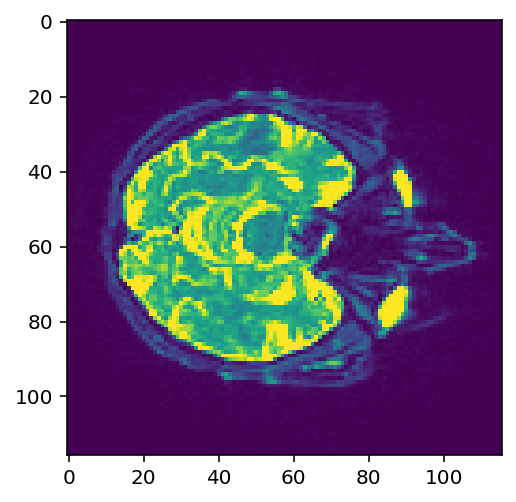

In [5]:
plt.imshow(data[:, :, 30, 0])


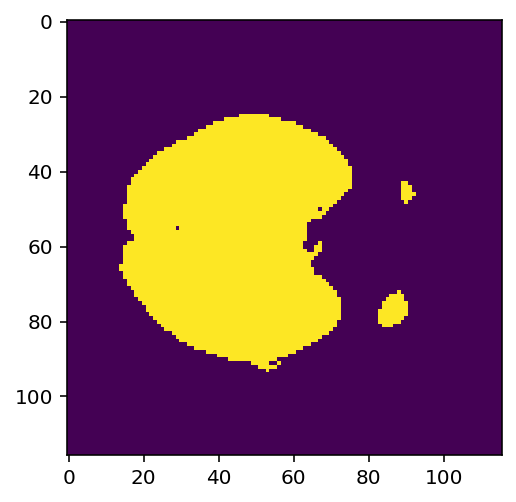

In [6]:
plt.imshow(mask[:, :, 30,])


In [7]:
data[mask == False] = np.zeros(data.shape[-1])

In [8]:
def load_masks(folder: Path, ident: str):
    mask, affine = load_nifti(folder / (ident + "_mask.nii.gz"))
    mask = mask.astype(np.bool)
    return mask

In [9]:
def mask_data(inputs):
    input_data: InputData = inputs[0]
    mask = inputs[1]
    input_data.data[mask == False] = np.zeros(input_data.data.shape[-1])
    
    return input_data

In [15]:
CSD_Peaks = namedtuple("CSD_Peaks", ("peak_model_file", "peak_model"))

def peaks_from_data(save_foler: Path, inputs):
    input_data: InputData = inputs[0]
    subject: str = inputs[1] 
    
    
    print(f"{datetime.now()}: Fitting CSD Model for subject {subject}")
    
    response, ratio = auto_response(input_data.gtab, input_data.data, roi_radius = 10, fa_thr=0.7)
    
    csd_model = ConstrainedSphericalDeconvModel(input_data.gtab, response)

    pam =  peaks_from_model(model=csd_model,
                            data=input_data.data,
                            sphere=default_sphere,
                           relative_peak_threshold=0.5,
                           min_separation_angle=25,
                           parallel=True)
    
    filename = str(save_foler / subject)
    
    #save_peaks(filename + ".pam5", pam)
    save_nifti(filename + "_dir.nii.gz", pam.peak_dirs, input_data.affine)
    save_nifti(filename + "_val.nii.gz", pam.peak_values, input_data.affine)

    print(f"saved sucessfully: {filename}")
    
    # drop model itself to free memory for large batch
    
    return CSD_Peaks(filename, None)

In [16]:
def peaks_from_data_3(save_foler: Path, inputs):
    input_data: InputData = inputs[0]
    subject: str = inputs[1] 
    
    
    print(f"{datetime.now()}: Fitting CSD Model for subject {subject}")
    
    response, ratio = auto_response(input_data.gtab, input_data.data, roi_radius = 10, fa_thr=0.7)
    
    
    tenmodel = dti.TensorModel(input_data.gtab)
    tenfit = tenmodel.fit(input_data.data, mask=input_data.data[..., 0] > 200)

    FA = fractional_anisotropy(tenfit.evals)
    MD = dti.mean_diffusivity(tenfit.evals)
    wm_mask = (np.logical_or(FA >= 0.4, (np.logical_and(FA >= 0.15, MD >= 0.0011))))

    response = recursive_response(input_data.gtab, input_data.data, mask=wm_mask, sh_order=8,
                                  peak_thr=0.01, init_fa=0.08,
                                  init_trace=0.0021, iter=8, convergence=0.001,
                                  parallel=True)
    
    csd_model = ConstrainedSphericalDeconvModel(input_data.gtab, response)

    pam =  peaks_from_model(model=csd_model,
                            data=input_data.data,
                            sphere=default_sphere,
                           relative_peak_threshold=0.5,
                           min_separation_angle=25,
                            npeaks=3,
                           parallel=True)
    
    filename = str(save_foler / subject)
    
    #save_peaks(filename + ".pam5", pam)
    save_nifti(filename + "_dir.nii.gz", pam.peak_dirs, input_data.affine)
    save_nifti(filename + "_val.nii.gz", pam.peak_values, input_data.affine)

    print(f"saved sucessfully: {filename}")
    
    # drop model itself to free memory for large batch
    
    return CSD_Peaks(filename, None)

In [17]:
subjects_to_data = partial(load_data, Path(r"F:\Uni\master\teamproject\preprocessed"))
subjects_to_mask = partial(load_masks, Path(r"F:\Uni\master\teamproject\masks"))
data_to_peaks = partial(peaks_from_data_3, Path(r"F:\Uni\master\teamproject\peaks"))



def get_pipeline(subjects):
    return zip(
        map(data_to_peaks, 
            zip(
                map(mask_data,
                    zip(
                        map(subjects_to_data, subjects), map(subjects_to_mask, subjects))
                   ),
                subjects
                )
           ),
        labels.Subject
    )


In [18]:
list(labels.groupby(["Sex", "Group"]))

[(('F', 'AD'),
     Image Data ID     Subject Group Sex  Age  Visit Modality Description  \
  1         376313  052_S_5062    AD   F   71     24      DTI   Axial DTI   
  2        1184057  022_S_6013    AD   F   63    103      DTI   Axial DTI   
  4        1186912  129_S_6763    AD   F   82      1      DTI   Axial DTI   
  6         254902  003_S_4142    AD   F   90     22      DTI   Axial DTI   
  
         Type             Acq Date Format  
  1  Original  2013-12-06 00:00:00    DCM  
  2  Original            6/21/2019    DCM  
  4  Original            7/15/2019    DCM  
  6  Original            8/31/2011    DCM  ),
 (('F', 'CN'),
      Image Data ID     Subject Group Sex  Age  Visit Modality Description  \
  8         1161685  029_S_6289    CN   F   58    102      DTI   Axial DTI   
  9          829304  002_S_1280    CN   F   81    101      DTI   Axial DTI   
  10         958925  070_S_6191    CN   F   56      1      DTI   Axial DTI   
  12         989328  002_S_1261    CN   F   82  

In [19]:
subjects_f = ["129_S_6763", "002_S_1261"]
subjects_m = ["094_S_4089", "023_S_6270"]

In [20]:
pipeline_all = get_pipeline(subjects_f)

In [21]:
csd_f = list(pipeline_all)

2020-07-08 17:47:59.506729: Fitting CSD Model for subject 129_S_6763


C:\tools\miniconda3\lib\site-packages\dipy\reconst\csdeconv.py:132: UserWarning:

Number of parameters required for the fit are more than the actual data points



saved sucessfully: F:\Uni\master\teamproject\peaks\129_S_6763
2020-07-08 18:01:41.801024: Fitting CSD Model for subject 002_S_1261
saved sucessfully: F:\Uni\master\teamproject\peaks\002_S_1261


In [44]:
def reshape_for_tractsect(folder: Path, subject: str):
    dirs = load_nifti(folder / (subject + "_dir.nii.gz"))[0]
    affine = load_nifti(folder / (subject + "_dir.nii.gz"))[1]
    vals = load_nifti(folder / (subject + "_val.nii.gz"))[0]
    scaled = directions * np.repeat(np.expand_dims(values, -1), 3, -1)
    
    cropped = scaled[:, :, :, :3, :].reshape(116,116,80,9)
    save_nifti(folder / (subject + "_scaled_3.nii.gz"), cropped, affine)
    print(f"Saved {subject} in {folder}")
    

In [25]:
partial_reshape = partial(reshape_for_tractsect, Path(r"F:\Uni\master\teamproject\peaks"))
list(map(partial_reshape, labels.Subject))


Saved 094_S_4282 in F:\Uni\master\teamproject\peaks
Saved 052_S_5062 in F:\Uni\master\teamproject\peaks
Saved 022_S_6013 in F:\Uni\master\teamproject\peaks
Saved 027_S_4802 in F:\Uni\master\teamproject\peaks
Saved 129_S_6763 in F:\Uni\master\teamproject\peaks
Saved 003_S_4136 in F:\Uni\master\teamproject\peaks
Saved 003_S_4142 in F:\Uni\master\teamproject\peaks
Saved 094_S_4089 in F:\Uni\master\teamproject\peaks
Saved 029_S_6289 in F:\Uni\master\teamproject\peaks
Saved 002_S_1280 in F:\Uni\master\teamproject\peaks
Saved 070_S_6191 in F:\Uni\master\teamproject\peaks
Saved 023_S_6270 in F:\Uni\master\teamproject\peaks
Saved 002_S_1261 in F:\Uni\master\teamproject\peaks
Saved 002_S_4225 in F:\Uni\master\teamproject\peaks


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [27]:
for_tractsect = load_nifti(r"F:\Uni\master\teamproject\peaks\003_S_4136_scaled_3.nii.gz")[0]
for_tractsect.shape

(116, 116, 80, 9)

In [23]:
directions = load_nifti(r"F:\Uni\master\teamproject\peaks\022_S_6013_dir.nii.gz")[0]
values = load_nifti(r"F:\Uni\master\teamproject\peaks\022_S_6013_val.nii.gz")[0]

In [24]:
scaled = directions * np.repeat(np.expand_dims(values, -1), 3, -1)
scaled.shape

(116, 116, 80, 5, 3)

In [4]:
print(directions.shape)
print(values.shape)

(116, 116, 80, 5, 3)
(116, 116, 80, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


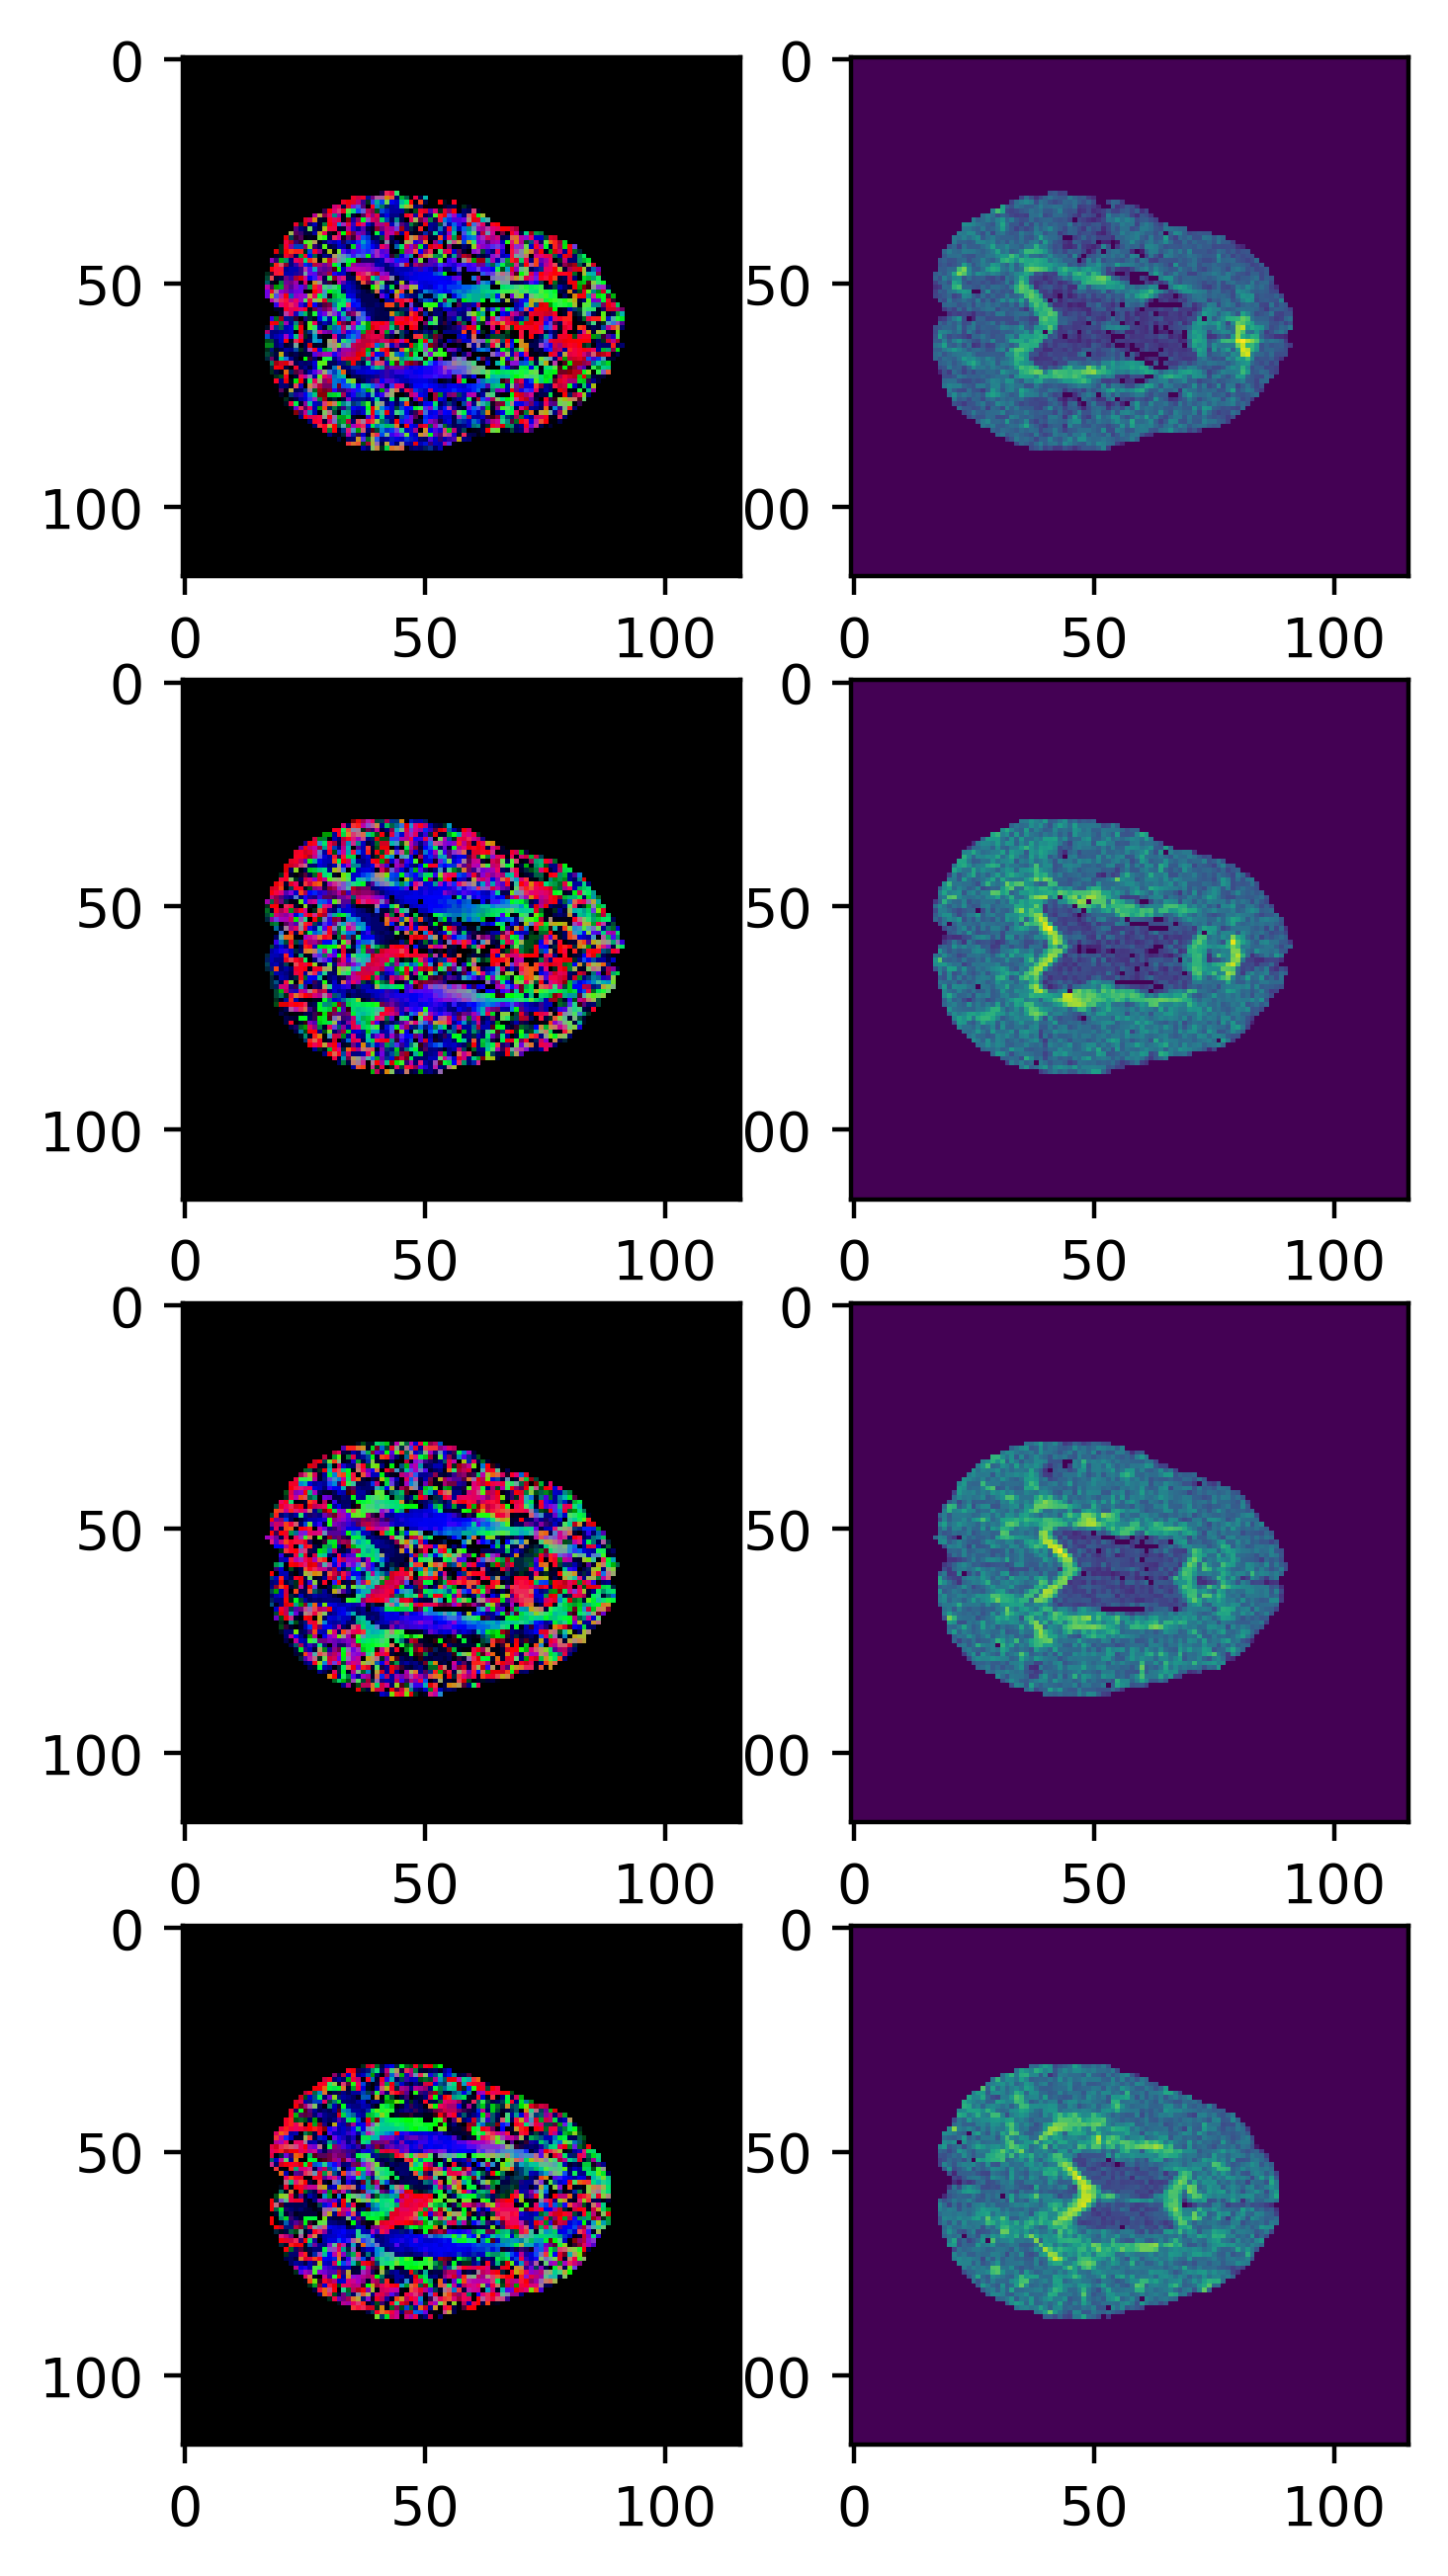

In [5]:
fig, axs = plt.subplots(4,2, dpi=200, figsize=(4,8))

for i in range(4):
    axs[i,0].imshow(directions[:, :, 41+2*i, 0], interpolation='nearest', aspect='auto')
    axs[i,1].imshow(values[:, :, 41+2*i, 0],interpolation='nearest', aspect='auto')




In [63]:
x = d[:, :, 41, 0] / np.repeat(np.linalg.norm(d[:, :, 41, 0], axis=-1).reshape(116,116,1), 3, -1)


C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [66]:
np.isnan(x)[np.isnan(x)].size

30513

In [18]:
directions.shape

(116, 116, 80, 5, 3)

In [15]:
tractseg_output = load_nifti(r"F:\Uni\master\teamproject\peaks\tractseg_output\bundle_segmentations\AF_left.nii.gz")[0]

In [22]:
tractseg_output.shape

(116, 116, 80)

In [18]:
unique, counts = np.unique(tractseg_output, return_counts=True)

In [19]:
unique

array([0, 1])

In [21]:
counts

array([1074436,    2044], dtype=int64)

In [25]:
TOM = load_nifti(r"F:\Uni\master\teamproject\peaks\tractseg_output\bundle_segmentations\AF_left.nii.gz")[0]

In [26]:
TOM.shape

(116, 116, 80)

In [27]:
np.unique(tractseg_output, return_counts=True)

(array([0, 1]), array([1074436,    2044], dtype=int64))

In [30]:
beginnings = load_nifti(r"F:\Uni\master\teamproject\peaks\tractseg_output\endings_segmentations\AF_left_b.nii.gz")[0]

In [31]:
np.unique(beginnings, return_counts=True)

(array([0, 1], dtype=int16), array([1074193,    2287], dtype=int64))

In [115]:
peak_folder = Path(r'F:/Uni/master/teamproject/peaks')
%matplotlib inline

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in true_divide



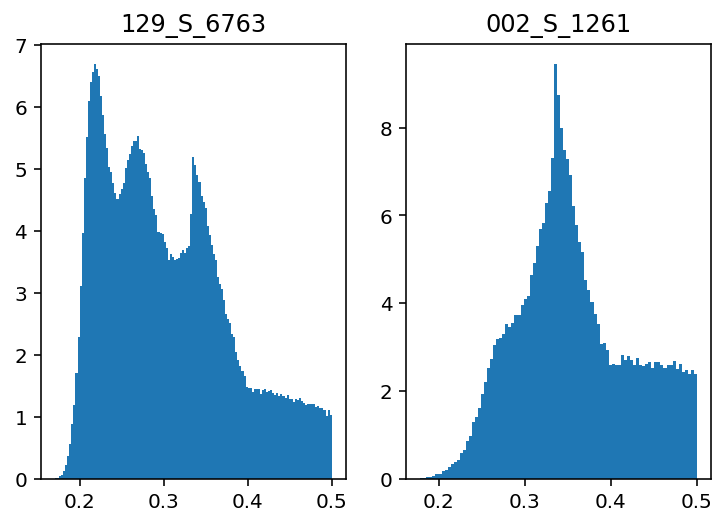

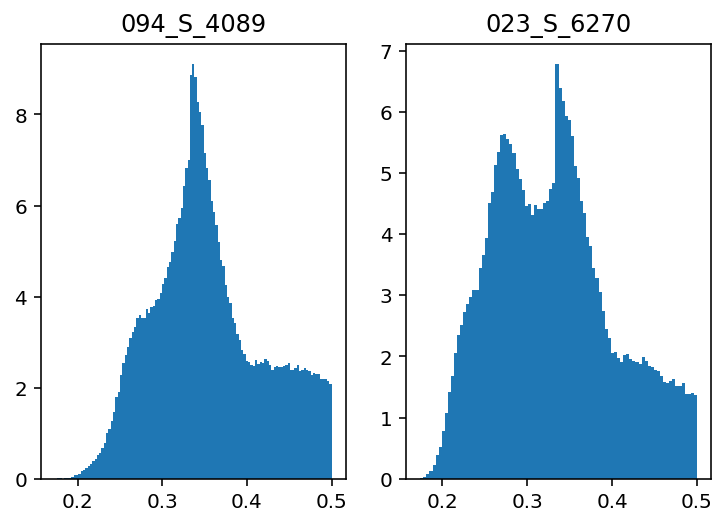

In [117]:
def plot_fraction_k(subjects, folder, k=1):
    
    s1, s2 = [load_nifti(folder /  (sj + "_val.nii.gz"))[0] for sj in subjects]
    
    mag_second_s1 =  s1[:, :, :, k] / np.sum(s1[:, :, :, :], axis = -1)
    mag_second_s1 = np.nan_to_num(mag_second_s1)
    fig, axs = plt.subplots(1,2)
    axs[0].hist(mag_second_s1.flatten()[mag_second_s1.flatten() != 0.0], bins="auto", density=True)
    axs[0].title.set_text(subjects[0])
    
    mag_second_s2 = np.nan_to_num(s2[:, :, :, 1] / np.sum(s2, axis=-1))
    axs[1].hist(mag_second_s2.flatten()[mag_second_s2.flatten() != 0.0], bins="auto", density=True)
    axs[1].title.set_text(subjects[1])
    plt.show()

    
plot_fraction_k(subjects_f, peak_folder, 1)
plot_fraction_k(subjects_m, peak_folder, 1)

In [127]:
def plot_fraction_k_single(subject, folder, label, k=1):
    s = load_nifti(folder /  (subject + "_val.nii.gz"))[0]
    
    mag_second_s =  s[:, :, :, k] / np.sum(s[:, :, :, :], axis = -1)
    mag_second_s = np.nan_to_num(mag_second_s)
    plt.figure()
    plt.hist(mag_second_s.flatten()[mag_second_s.flatten() != 0.0], bins="auto", density=True)
    plt.title(f"{subject} - {label}")
    
    plt.show()


In [137]:
subjects_f

['129_S_6763', '002_S_1261']

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



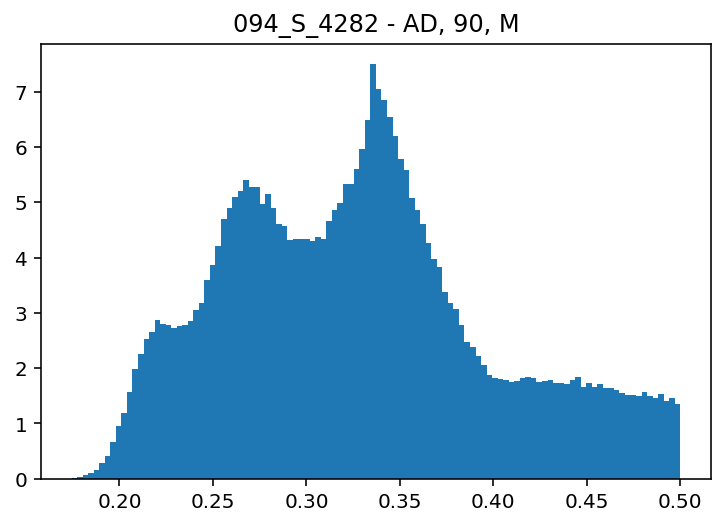

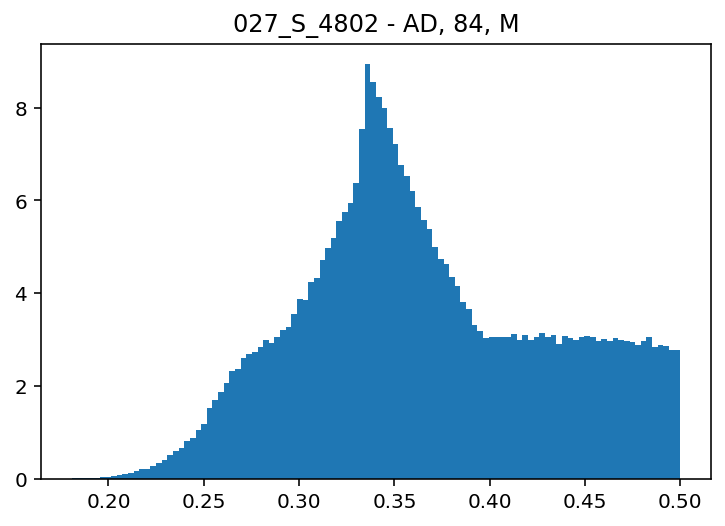

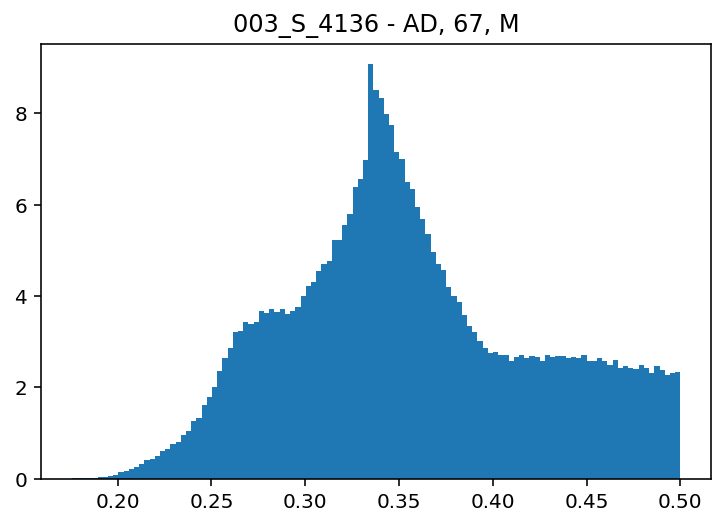

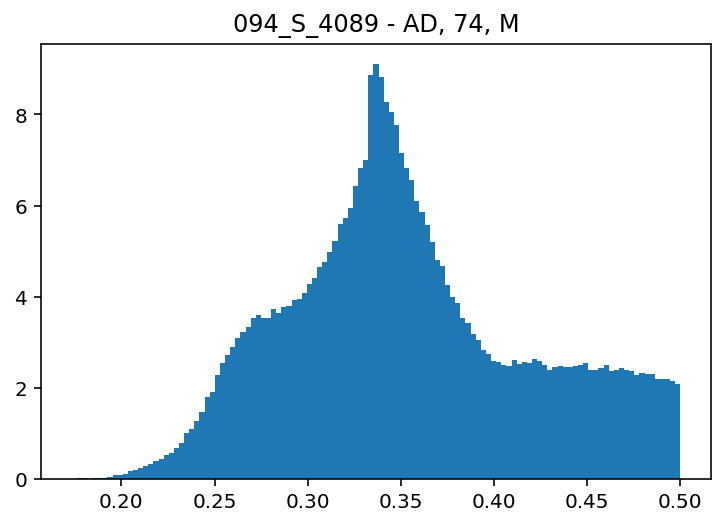

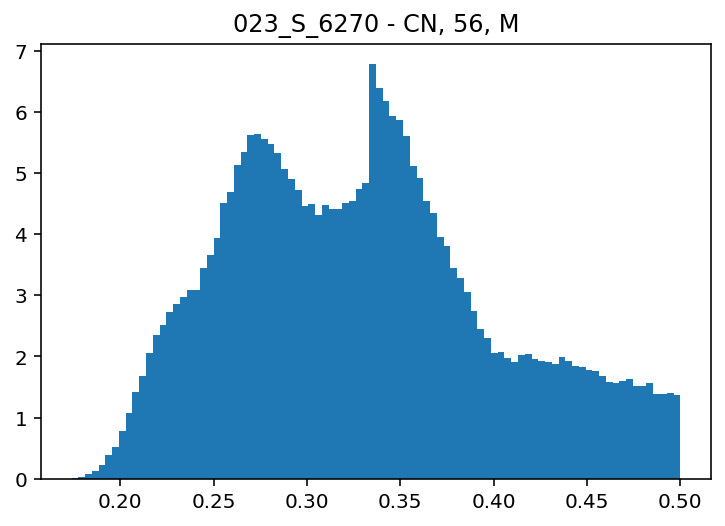

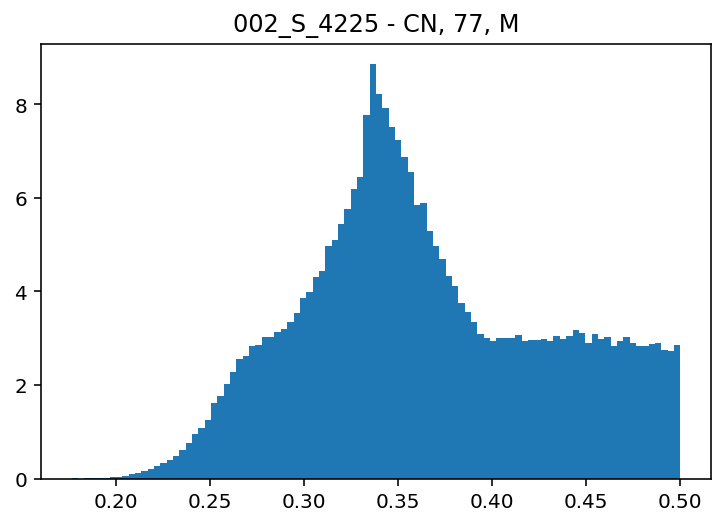

In [138]:
comp = labels[labels.Sex == 'M']
for sj, lbl, age, sex in zip(comp.Subject, comp.Group, comp.Age, comp.Sex):
    plot_fraction_k_single(sj, peak_folder, f"{lbl}, {age}, {sex}", 1)

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



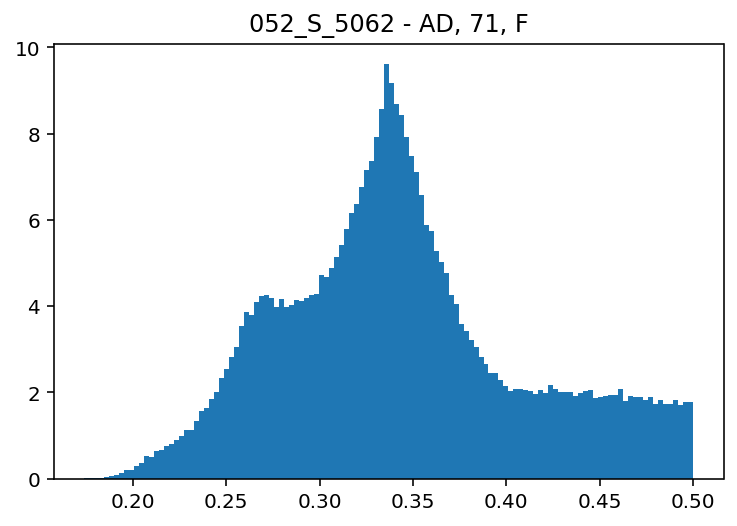

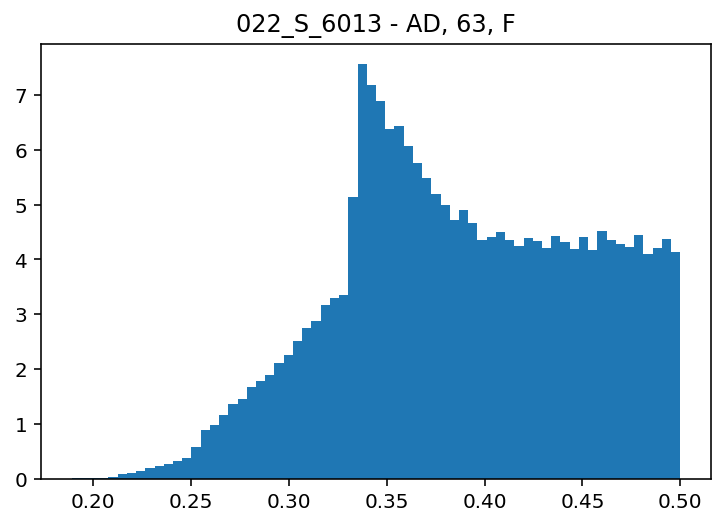

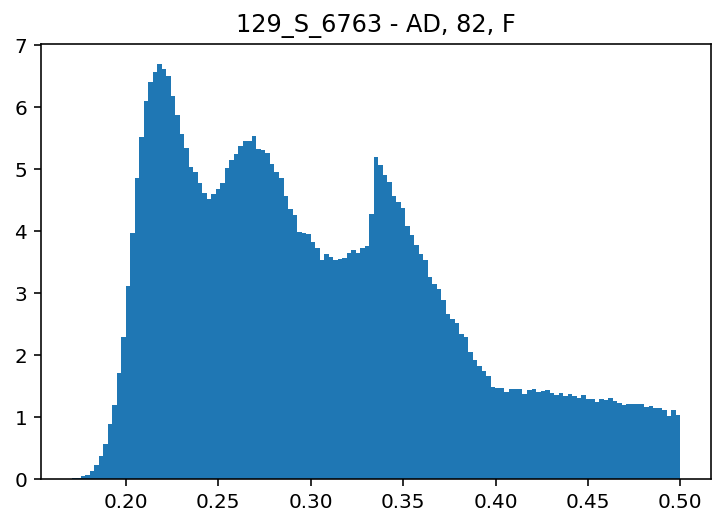

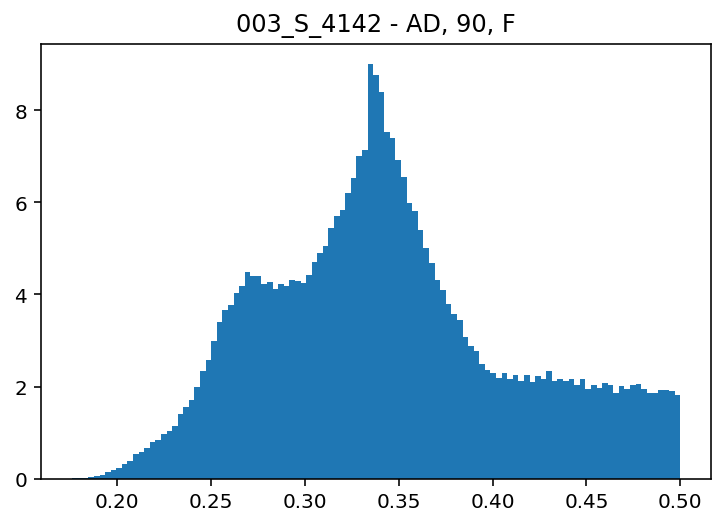

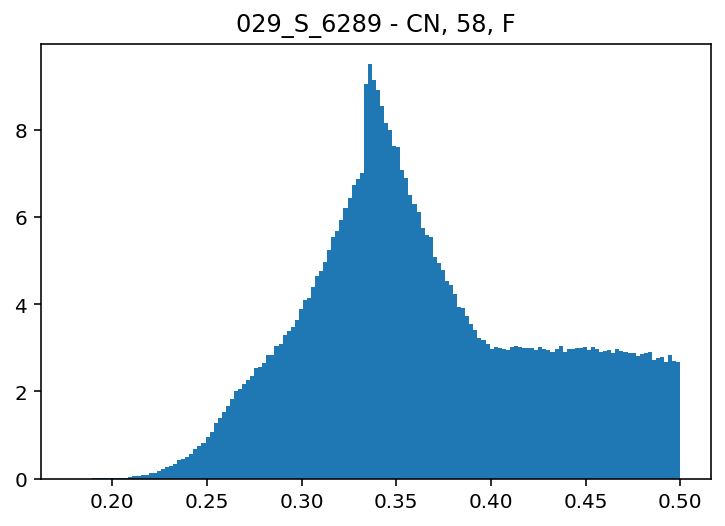

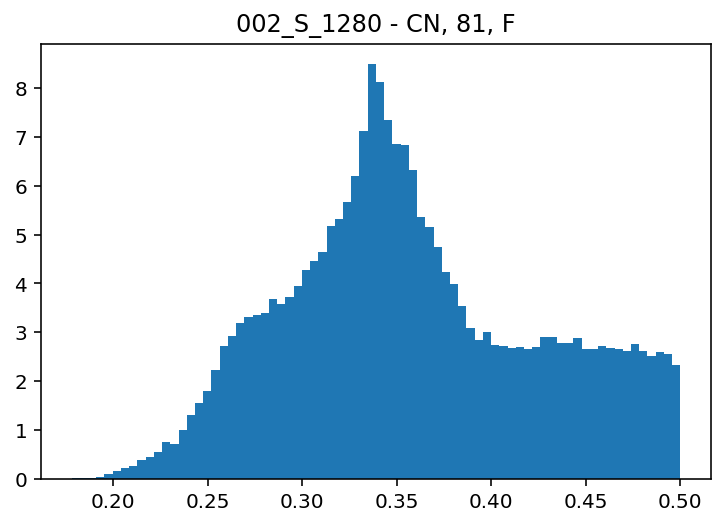

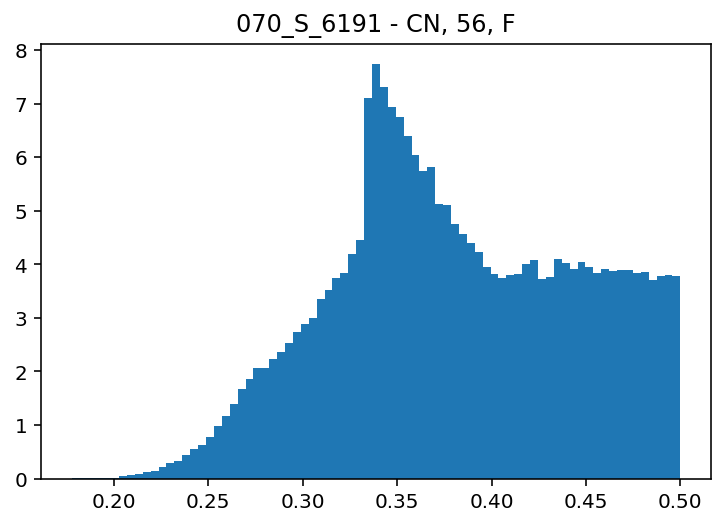

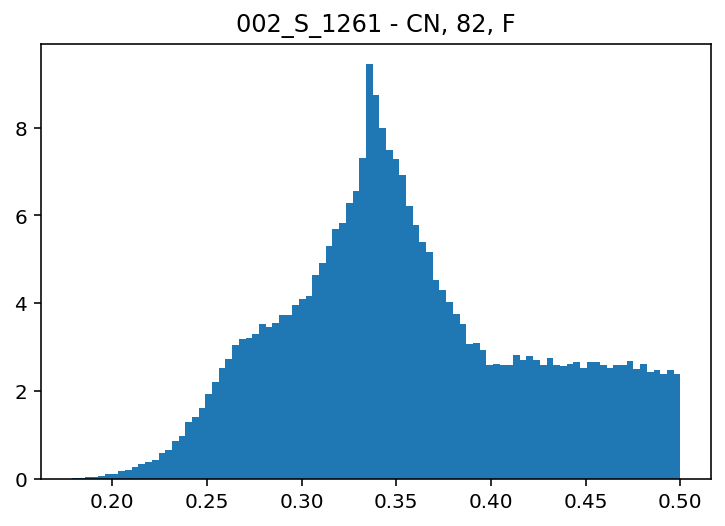

In [174]:
comp = labels[labels.Sex == 'F']
for sj, lbl, age, sex in zip(comp.Subject, comp.Group, comp.Age, comp.Sex):
    plot_fraction_k_single(sj, peak_folder, f"{lbl}, {age}, {sex}", 1)

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide



<IPython.core.display.Javascript object>


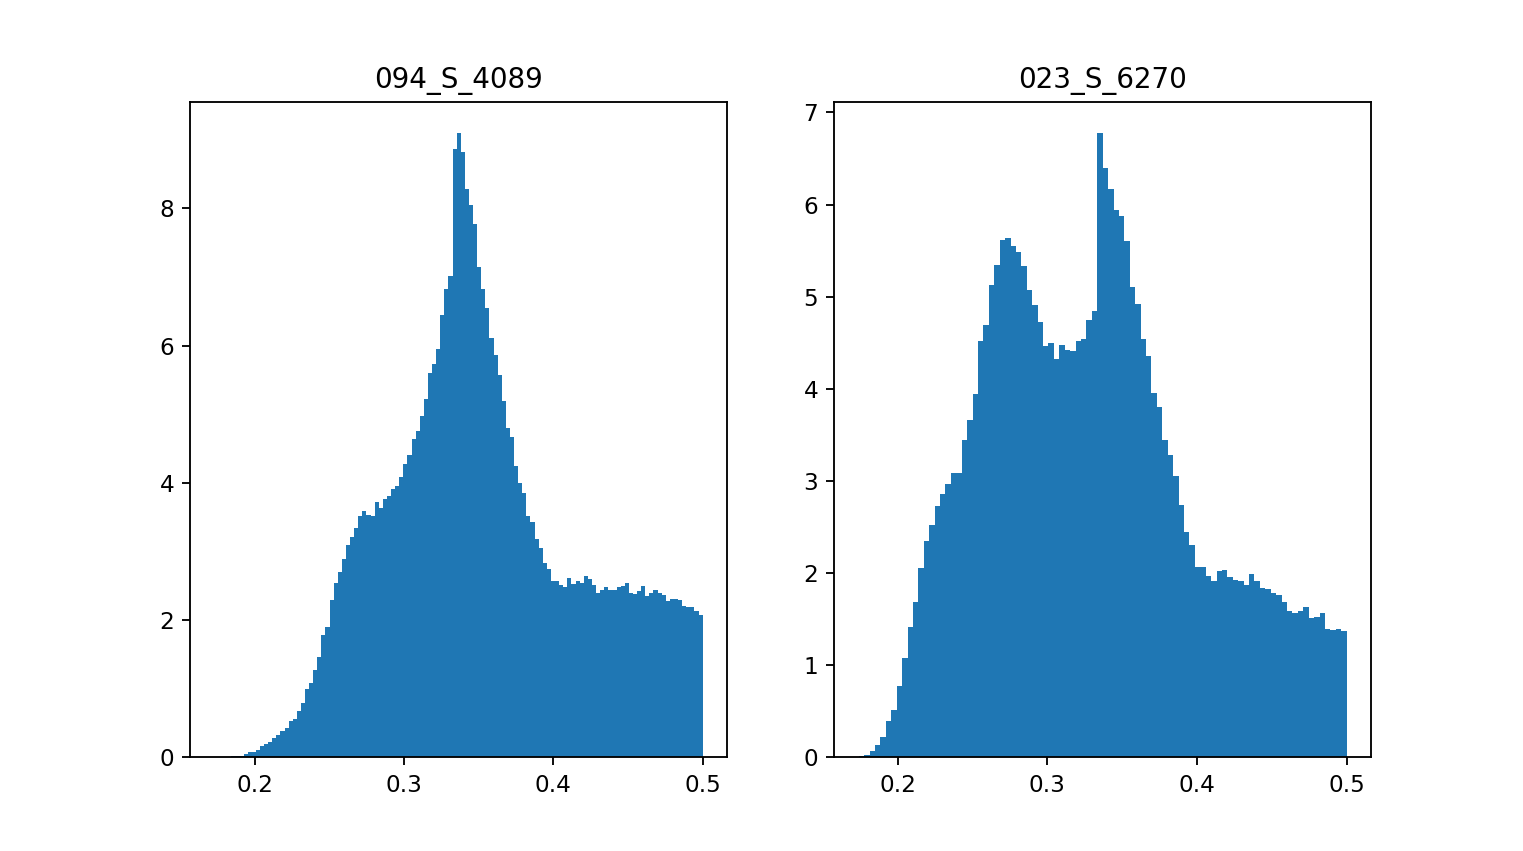

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in true_divide



In [114]:
plot_fraction_k(subjects_m, peak_folder, 1)

In [140]:
from sklearn import decomposition

In [144]:
data = load_nifti(peak_folder / (subjects_f[0] + "_dir.nii.gz"))[0]
data.shape

(256, 256, 80, 5, 3)

In [159]:
decomp = decomposition.PCA()
decomp.fit(data.reshape(256*256*80, 5 * 3).T)

PCA()

In [162]:
decomp.singular_values_

array([6.88222238e+02, 5.61662861e+02, 5.54775775e+02, 5.05923266e+02,
       4.94935450e+02, 4.26470099e+02, 3.99610063e+02, 3.36898894e+02,
       3.24661410e+02, 2.85248792e+02, 2.73977363e+02, 2.53577202e+02,
       2.39645788e+02, 1.94446181e+02, 2.84650518e-11])

In [160]:
data2 = load_nifti(peak_folder / (subjects_f[1] + "_dir.nii.gz"))[0]
decomp2 = decomposition.PCA()
decomp2.fit(data2.reshape(116*116*80, 5 * 3).T)
decomp2.singular_values_

array([2.72650885e+02, 2.61700004e+02, 2.51787837e+02, 2.05672744e+02,
       2.00012938e+02, 1.45815785e+02, 1.44631192e+02, 1.27589143e+02,
       1.16793364e+02, 7.40973270e+01, 7.11705179e+01, 4.99349526e+01,
       2.02264137e+01, 1.97143337e+01, 4.87617218e-12])

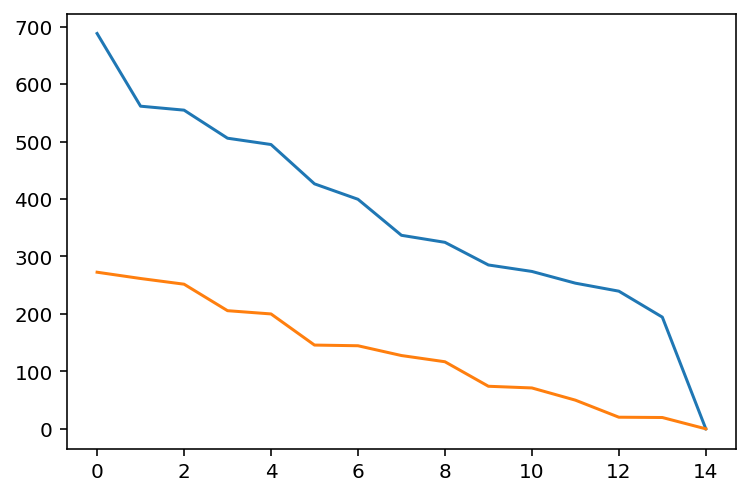

In [161]:
plt.plot(decomp.singular_values_)
plt.plot(decomp2.singular_values_)

In [163]:
data2 = load_nifti(peak_folder / (subjects_f[1] + "_val.nii.gz"))[0]
decomp2 = decomposition.PCA()
decomp2.fit(data2.reshape(116*116*80, 5).T)


PCA()

In [164]:
data1 = load_nifti(peak_folder / (subjects_f[0] + "_val.nii.gz"))[0]
decomp1 = decomposition.PCA()
decomp1.fit(data2.reshape(116*116*80, 5).T)


PCA()

In [173]:
decomp2.singular_values_

array([2.74302518e+02, 1.13094686e+02, 6.26847834e+01, 3.15557660e+01,
       1.47486644e-12])

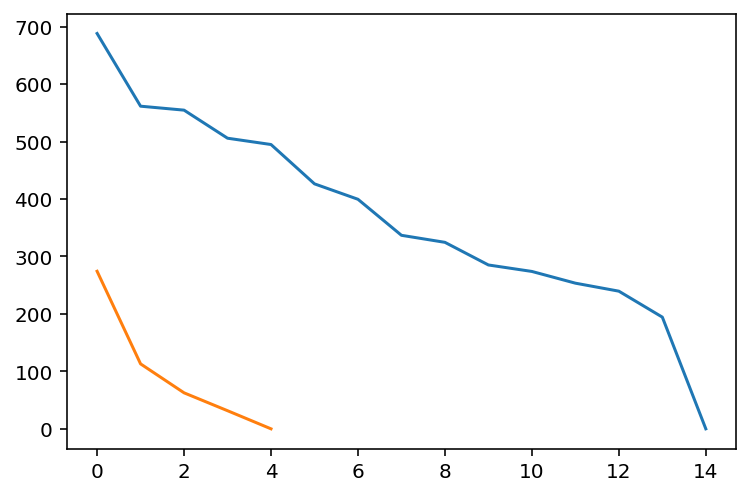

In [166]:
plt.figure()
plt.plot(decomp.singular_values_)
plt.plot(decomp2.singular_values_)

In [169]:
def value_pca(sj):
    data2 = load_nifti(peak_folder / (sj + "_val.nii.gz"))[0]
    decomp2 = decomposition.PCA()
    samplecnt = data2.shape[0] * data2.shape[1] * data2.shape[2]
    decomp2.fit(data2.reshape(samplecnt, 5).T)
    return decomp2

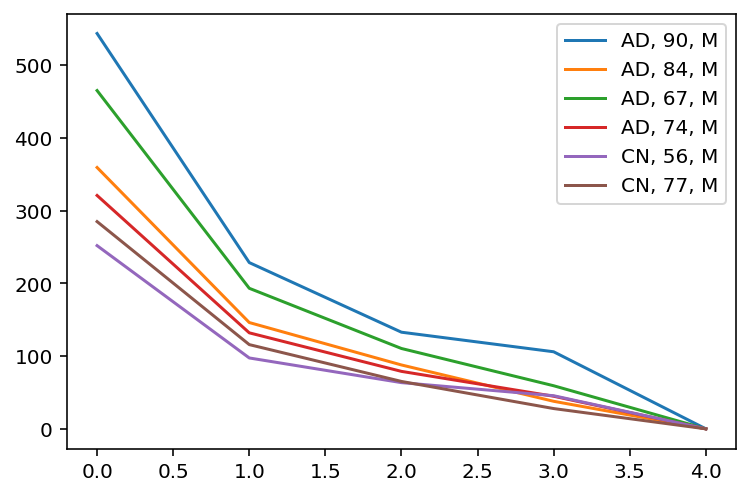

In [171]:
comp = labels[labels.Sex == 'M']
plt.figure()
for sj, lbl, age, sex in zip(comp.Subject, comp.Group, comp.Age, comp.Sex):
    decomp = value_pca(sj)
    plt.plot(decomp.singular_values_, label=f'{lbl}, {age}, {sex}')
plt.legend()
plt.show()

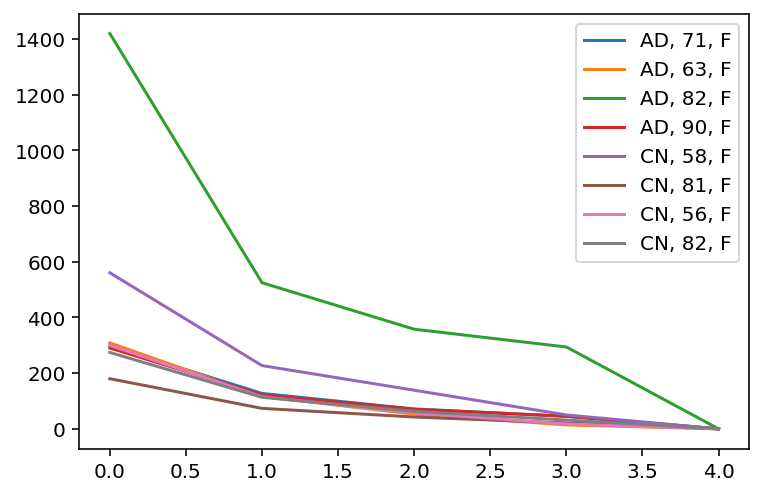

In [172]:
comp = labels[labels.Sex == 'F']
plt.figure()
for sj, lbl, age, sex in zip(comp.Subject, comp.Group, comp.Age, comp.Sex):
    decomp = value_pca(sj)
    plt.plot(decomp.singular_values_, label=f'{lbl}, {age}, {sex}')
plt.legend()
plt.show()

In [177]:
plt.plot(data)

(116, 116, 80, 5)

In [22]:
trk_data = load_trk(r"F:\Uni\master\teamproject\cpcg\data\599469\roi_masks\CG_left.trk",
         r"F:\Uni\master\teamproject\lukas_data\Diffusion\data.nii.gz")

diff_volume, affine = load_nifti(r"F:\Uni\master\teamproject\lukas_data\Diffusion\data.nii.gz")
trk_data.to_vox()

In [28]:
str1 = trk_data.streamlines[0].astype(np.int16)

In [4]:
all_steamlines = np.vstack(trk_data.streamlines).astype(np.int32)


In [5]:
diff_volume[all_steamlines[:, 0], all_steamlines[:, 1], all_steamlines[:, 2], :].shape

(755896, 288)

In [25]:
x, y, z = np.meshgrid(np.linspace(-10, 10, 116),
                      np.linspace(-10, 10, 116),
                      np.linspace(-10, 10, 80))


u =     directions[:,:,:,0,0]
v =     directions[:,:,:,0,1]
w =     directions[:,:,:,0,2]

ipv.figure()
quiver = ipv.quiver(x.flatten(), y.flatten(), z.flatten(), u.flatten(), v.flatten(), w.flatten(),
                   size = 0.9)
ipv.show()

In [32]:
diff_volume.shape

(145, 174, 145, 288)

In [9]:
mask_volume = np.zeros((145,174,145)).astype(np.bool)
mask_volume[all_steamlines[:, 0], all_steamlines[:, 1], all_steamlines[:, 2]] = True
mask_volume.shape

(145, 174, 145)

In [19]:
hcp_example = Path(r"F:\Uni\master\teamproject\lukas_data\Diffusion")

res = peaks_from_data(hcp_example, (load_data(hcp_example, "data"), "data"))

2020-07-08 11:52:03.797909: Fitting CSD Model for subject data
saved sucessfully: F:\Uni\master\teamproject\lukas_data\Diffusion\data


In [20]:
hcp_peaks, _ = load_nifti(r"F:\Uni\master\teamproject\lukas_data\Diffusion\data_dir.nii.gz")

In [32]:
hcp_peaks.shape

(145, 174, 145, 5, 3)

In [36]:
ipv.figure()


x, y, z = np.meshgrid(np.linspace(0, 145, 145),
                      np.linspace(0, 174, 174),
                      np.linspace(0, 145, 145))

u =     hcp_peaks[:,:,:,0,0]
v =     hcp_peaks[:,:,:,0,1]
w =     hcp_peaks[:,:,:,0,2]

ipv.figure()
quiver = ipv.quiver(x.flatten(), y.flatten(), z.flatten(), u.flatten(), v.flatten(), w.flatten(),
                   size = 0.1)

ipv.volshow(mask_volume)

ipv.show()

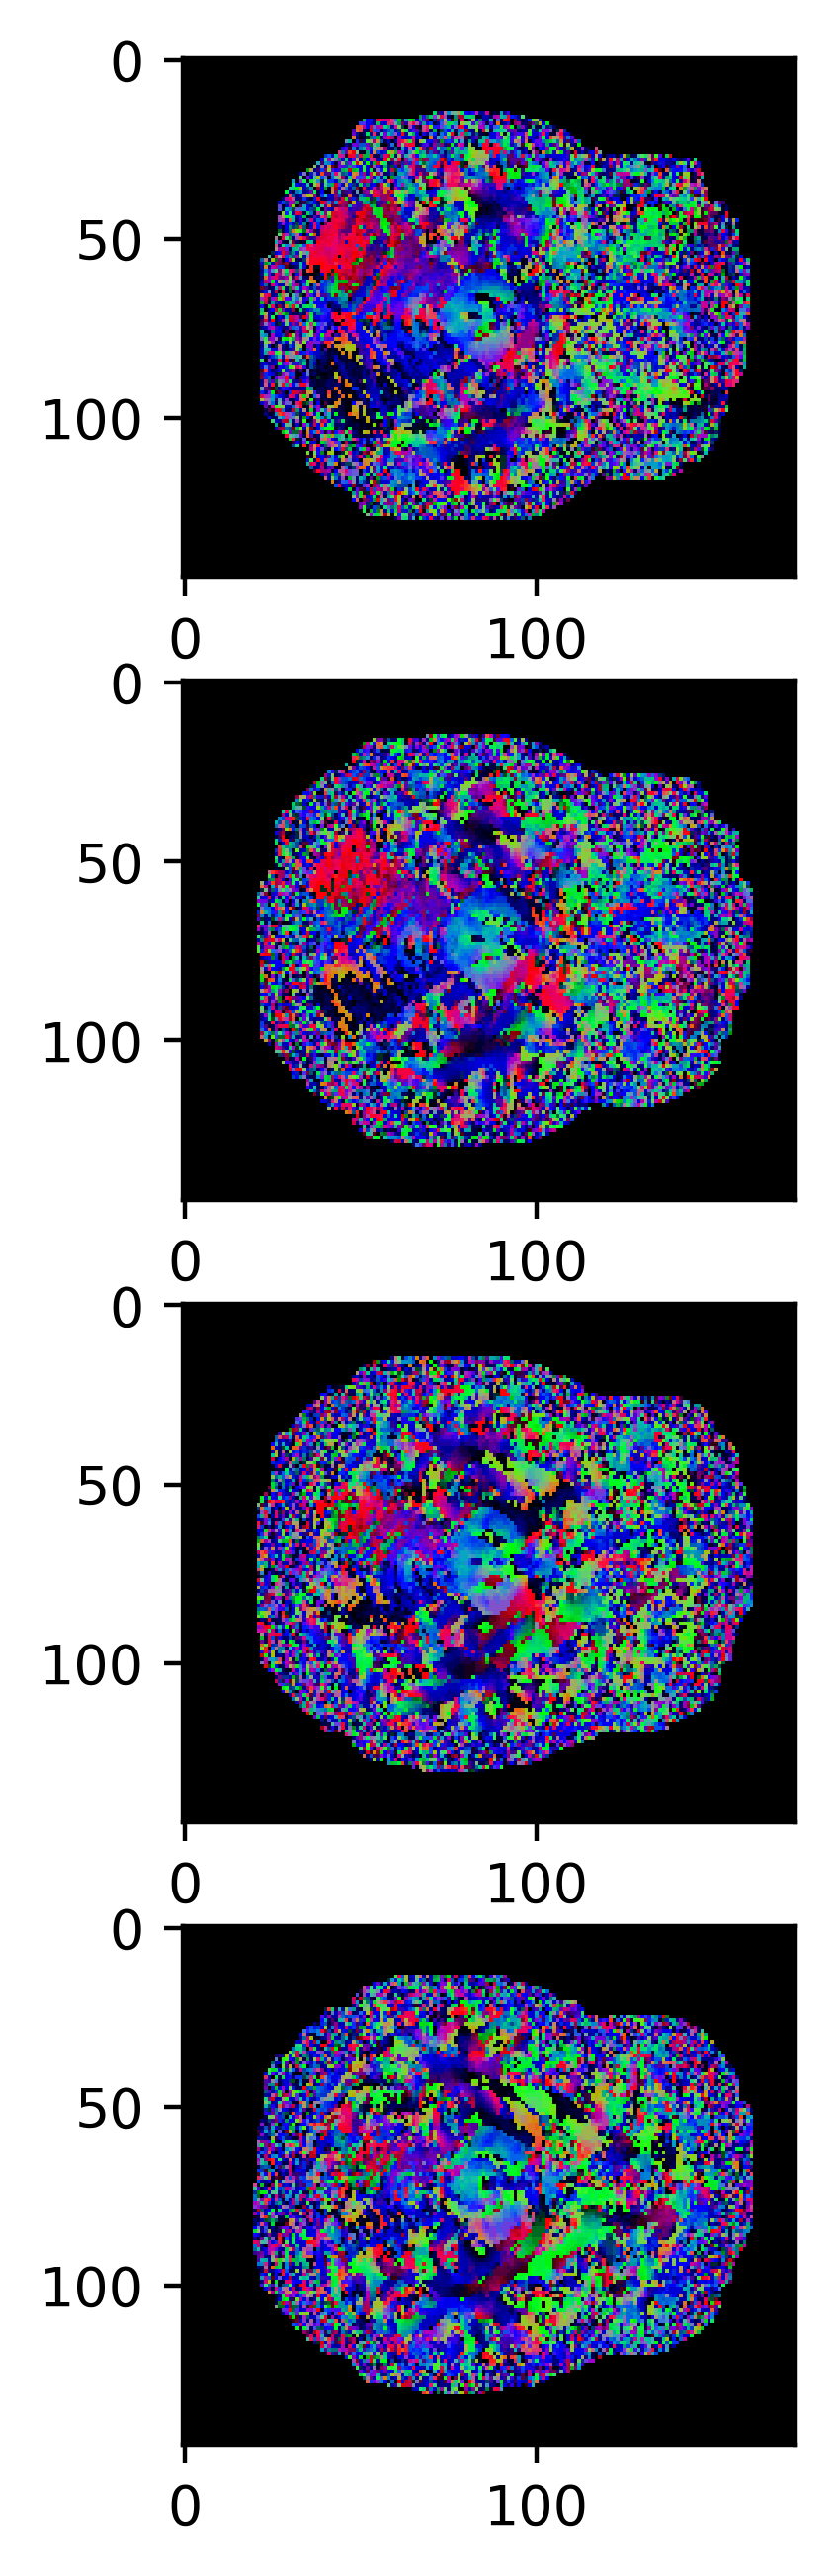

In [43]:
fig, axs = plt.subplots(4,1, dpi=200, figsize=(2,8))

for i in range(4):
    axs[i].imshow(hcp_peaks[:, :, 41+2*i, 0], interpolation='nearest', aspect='auto')


In [45]:
reshape_for_tractsect(hcp_example, "data")

Saved data in F:\Uni\master\teamproject\lukas_data\Diffusion


In [56]:
peaks_from_data_3(hcp_example, (load_data(hcp_example, "data"), "data"))

2020-07-08 15:14:23.415758: Fitting CSD Model for subject data
saved sucessfully: F:\Uni\master\teamproject\lukas_data\Diffusion\data


CSD_Peaks(peak_model_file='F:\\Uni\\master\\teamproject\\lukas_data\\Diffusion\\data', peak_model=None)

In [57]:
reshape_for_tractsect(hcp_example, "data")

Saved data in F:\Uni\master\teamproject\lukas_data\Diffusion


In [ ]:
peaks_from_data_3(hcp_example, (load_data(hcp_example, "data"), "data"))